In [3374]:
import numpy as np # linear algebra
import pandas as pd # rawprocessing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3375]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)
from implicitdl import ImplicitModel, ImplicitModelLoRA, ImplicitModelLoRA2, ImplicitFunctionInf, ImplicitFunctionTriu, ImplicitRNNCell, MyRNNCell, ImplicitRNNCellLoRA, SimpleRNN, LSTM, GRU

In [3376]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3377]:
df = pd.read_csv("./kaggle/input/NetflixDataset.csv")
df.head()
df[["year", "month", "dates"]] = df["Date"].str.split("-", expand = True)
df = df.tail(2500)
# Calculate moving averages
df['MA30'] = df['Close'].rolling(window=30).mean()
df['MA90'] = df['Close'].rolling(window=90).mean()

# Volatility Analysis

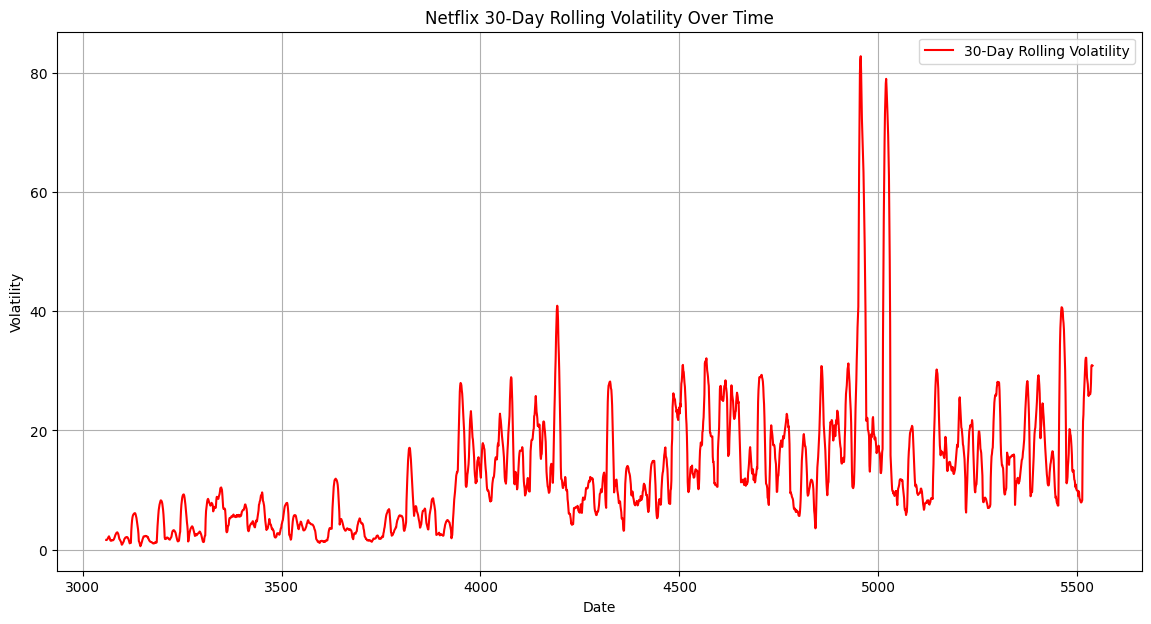

In [3378]:
# Calculate rolling standard deviation (volatility)
df['Volatility'] = df['Close'].rolling(window=20).std()
# Plot volatility over time
plt.figure(figsize=(14, 7))
plt.plot(df['Volatility'], label='30-Day Rolling Volatility', color='red')
plt.title('Netflix 30-Day Rolling Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Data Extraction

In [3379]:
# Predict Adj Close
fea_name = "Volatility"
# fea_name = "Close"
df = df.tail(2470)
rm_name = ['Open', 'Close', 'High', 'Low', 'Volume','MA30' ,'MA90', 'Volatility', 'year', 'month', 'dates', "Adj Close"]
rm_name.remove(fea_name)
df.drop(columns=rm_name, inplace=True)
df.head()

,Date,Volatility
3070,2014-08-04,1.513664
3071,2014-08-05,1.528089
3072,2014-08-06,1.504224
3073,2014-08-07,1.582783
3074,2014-08-08,1.616487


In [3380]:
scaler = MinMaxScaler(feature_range=(-1, 1))
model=scaler.fit(df[fea_name].values.reshape(-1,1))
df[fea_name]=model.transform(df[fea_name].values.reshape(-1,1))
df.head()

,Date,Volatility
3070,2014-08-04,-0.977407
3071,2014-08-05,-0.977056
3072,2014-08-06,-0.977637
3073,2014-08-07,-0.975725
3074,2014-08-08,-0.974905


In [3381]:
df[fea_name].values.reshape(-1,1)

array([[-0.97740697],
       [-0.97705602],
       [-0.97763666],
       ...,
       [-0.26066834],
       [-0.26151636],
       [-0.26308966]])

# Test and Train dataset

In [3382]:
# function to create train, test data given stock data and sequence length
# we are predicting future so last portion of our data will be recorded as the test dataset example 50000 datapoints last 10k rakhlo future ka lia
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    print("len(data_raw): ",len(data_raw))
    
    # create all possible sequences of length look_back
    # we will take data example 0 to 60 then 1 to 61 then 2 to 62 ------ window size 
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index:index + look_back])
    #print(data[0:3])
    data = np.array(data)
    print("data.shape: ", data.shape)

    test_set_size = int(np.round(0.4*data.shape[0])) #30 percent for test
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length # window size
x_train, y_train, x_test, y_test = load_data(df[[fea_name]], look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

len(data_raw):  2470
data.shape:  (2410, 60, 1)
x_train.shape =  (1446, 59, 1)
y_train.shape =  (1446, 1)
x_test.shape =  (964, 59, 1)
y_test.shape =  (964, 1)


In [3383]:
from typing import Optional

class CustomInf(ImplicitFunctionInf):
    """
    Change the default convergence parameters.
    """
    mitr = grad_mitr = 500
    tol = grad_tol = 1e-6
    
def fuse_parameters(model):
    """Move model parameters to a contiguous tensor, and return that tensor."""
    n = sum(p.numel() for p in model.parameters())
    params = torch.zeros(n)
    i = 0
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        params_slice.copy_(p.flatten())
        p.data = params_slice.view(p.shape)
        i += p.numel()
    return params

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, act):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size, bias=False),
            act(),
            nn.Linear(hidden_size, hidden_size, bias=False),
            act(),
            # nn.Linear(hidden_size, hidden_size, bias=False),
            # act(),
            nn.Linear(hidden_size, output_dim, bias=False),
        )
    def forward(self, x):
        x1 = x.flatten(1,-1)
        return self.model(x1)
    
# Here we define our model as a class
# class LSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#         super().__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bias=False)
#         self.fc = nn.Linear(hidden_dim, output_dim, bias=False)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
#         out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #.detach() is a PyTorch method that creates a new tensor that does not require gradients. 
#         out = self.fc(out[:, -1, :])
#         return out

class ImplicitRNN(nn.Module):
    def __init__(self, input_size, n, hidden_size, output_size, **kwargs):
        super().__init__()
        self.recurrent = ImplicitRNNCell(input_size, n, hidden_size, **kwargs)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        _, h = self.recurrent(x)
        return self.linear(h)

class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()
        self.recurrent = MyRNNCell(input_size, hidden_size, **kwargs)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        _, h = self.recurrent(x)
        return self.linear(h)
    
class ImplicitRNNLoRA(nn.Module):
    def __init__(self, lora_size, input_size, n, hidden_size, output_size, **kwargs):
        super().__init__()
        self.implicit = ImplicitRNNCellLoRA(lora_size, input_size, n, hidden_size, **kwargs)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        _, h = self.implicit(x)
        return self.linear(h)

In [3384]:
input_size = x_train.shape[1]
lora_size = 1
hidden_size = 22
output_size = 1
more_state = 2

make_imp_relu = lambda: ImplicitModel(hidden_size-5, input_size, output_size, f=CustomInf, no_D=False)
make_imp_triu_l = lambda: ImplicitModel(hidden_size+more_state, input_size, output_size, f=ImplicitFunctionTriu, no_D=False)
make_imp_triu_s = lambda: ImplicitModel(hidden_size, input_size, output_size, f=ImplicitFunctionTriu, no_D=False)
make_imp_lora = lambda: ImplicitModelLoRA(lora_size, hidden_size, input_size, output_size, f=CustomInf, no_D=False)
make_imp_lora2 = lambda: ImplicitModelLoRA2(lora_size, hidden_size, input_size, output_size, f=CustomInf, no_D=False, diag=True)
make_imp_lora3 = lambda: ImplicitModelLoRA2(lora_size, hidden_size, input_size, output_size, f=CustomInf, no_D=False, diag=False)
make_imp_rnn = lambda: ImplicitRNN(1, hidden_size, hidden_size, output_size, f=CustomInf, no_D=False)
make_rnn = lambda: MyRNN(1, hidden_size+6, output_size, f=CustomInf, no_D=False)
make_simple_rnn = lambda: SimpleRNN(1, hidden_size-1, 2, True, output_size, 'relu')
# make_simple_rnn = lambda: LSTM(1, hidden_size-12, 2, True, output_size)
# make_simple_rnn = lambda: MultiLayerLSTM(1, hidden_size-11, 2, 0.01)
make_imp_rnn_lora = lambda: ImplicitRNNLoRA(lora_size, 1, hidden_size, hidden_size, output_size, f=CustomInf, no_D=False)

# Define LSTM 

In [3385]:
import torch
import torch.nn as nn


# Build model
input_dim = 1
hidden_dim = 12 #15
num_layers = 2
output_dim = 1

# model, lr = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device), 0.08
# model, lr = MLP(input_size, hidden_size, output_size, nn.ReLU).to(device), 0.005
# model, lr = make_imp_relu().to(device), 0.01
# model, lr = make_imp_lora().to(device), 0.02
# model, lr = make_imp_lora2().to(device), 0.02
# model, lr = make_imp_lora3().to(device), 0.02
# model, lr = make_imp_rnn().to(device), 0.004
# model, lr = make_imp_rnn_lora().to(device), 0.008
# model, lr = make_rnn().to(device), 0.004
model, lr = make_simple_rnn().to(device), 0.05

model.to(device)
print(f'model size: {sum(p.numel() for p in model.parameters())} parameters')

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=lr)

# Example forward pass
x_example = torch.randn(10, 59, input_dim).to(device)  # Example input tensor
output_example = model(x_example)
print(output_example, output_example.shape)


model size: 1450 parameters
tensor([[-0.1239],
        [-0.1194],
        [-0.0898],
        [-0.0993],
        [-0.1247],
        [-0.1215],
        [-0.0968],
        [-0.1110],
        [-0.1205],
        [-0.1192]], grad_fn=<AddmmBackward0>) torch.Size([10, 1])


# Train Model

In [3386]:
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Forward pass
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()


Epoch  10 MSE:  0.03882317617535591
Epoch  20 MSE:  0.03112010471522808
Epoch  30 MSE:  0.026650767773389816
Epoch  40 MSE:  0.025479860603809357
Epoch  50 MSE:  0.022518804296851158
Epoch  60 MSE:  0.016909854486584663
Epoch  70 MSE:  0.004672270733863115
Epoch  80 MSE:  0.0030605841893702745
Epoch  90 MSE:  0.0016260277479887009


In [3387]:
# plt.plot(hist, label="Training loss")
# plt.legend()
# plt.show()

# Make Predictions


In [3388]:
x_test = x_test.to(device)
y_test_pred = model(x_test)
y_test_pred = y_test_pred.cpu().detach().numpy()
y_test= y_test.cpu().detach().numpy()
x_train= x_train.cpu().detach().numpy()
x_test= x_test.cpu().detach().numpy()
y_train= y_train.cpu().detach().numpy()

In [3389]:
print(y_test_pred.shape, y_test.shape)
print(*zip(y_test_pred[0:5], y_test[0:5]))

(964, 1) (964, 1)
(array([-0.35896653], dtype=float32), array([-0.4125447], dtype=float32)) (array([-0.39157173], dtype=float32), array([-0.4809969], dtype=float32)) (array([-0.4447734], dtype=float32), array([-0.5355505], dtype=float32)) (array([-0.50572634], dtype=float32), array([-0.5357053], dtype=float32)) (array([-0.529289], dtype=float32), array([-0.549979], dtype=float32))


# Accuracy score

In [3390]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_pred, y_test)
r2 = r2_score(y_test_pred, y_test)
print(f'r2 (higher better):    {r2:.2f}')
print(f'MAPE (smaller better): {mape:.2f}') 

r2 (higher better):    -0.00
MAPE (smaller better): 0.22


# Inverse transform

to see how accurate our results are on line Graph

In [3391]:
# Inverse transform y_test_pred and y_test
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

In [3392]:
len(y_train), len(y_test)

(1446, 964)

# Results

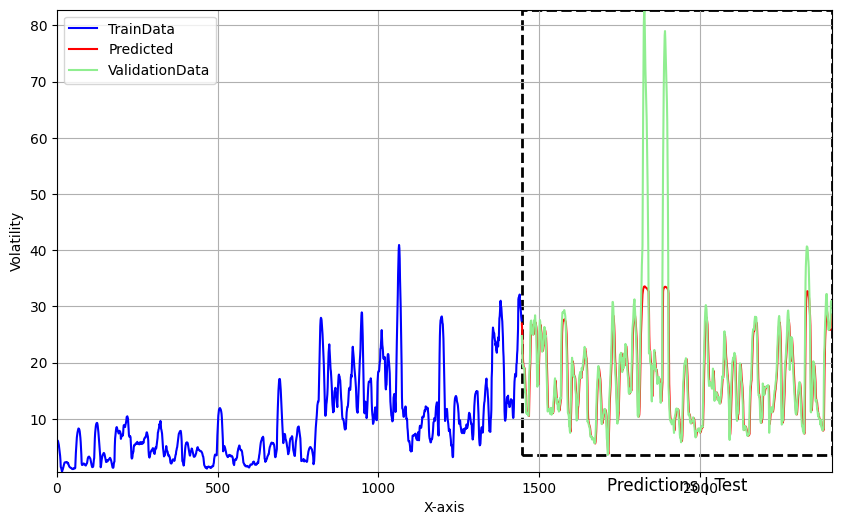

In [3393]:
import matplotlib.patches as patches

# Assuming y_train, y_test_pred, and y_test are already defined
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Plot y_train with a different color
plt.plot(range(len(y_train)), y_train, label='TrainData', color='blue')  

# Plot y_test_pred and y_test with different colors
plt.plot(range(len(y_train), len(y_train) + len(y_test_pred)), y_test_pred, label='Predicted', color='red')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='ValidationData', color='lightgreen')

# Set the y-axis limits based on the minimum and maximum values of both arrays
plt.ylim(min(y_train.min(), y_test_pred.min(), y_test.min()), max(y_train.max(), y_test_pred.max(), y_test.max()))

# Set the x-axis limits
plt.xlim(0, len(y_train) + len(y_test))

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel(fea_name)

# Display the legend
plt.legend()

# Add a square around the y_test_pred
ax = plt.gca()
rect = patches.Rectangle((len(y_train), min(y_test_pred.min(), y_test.min())), len(y_test_pred), 
                         max(y_test_pred.max(), y_test.max()) - min(y_test_pred.min(), y_test.min()), 
                         linewidth=2, edgecolor='black', facecolor='none', linestyle='--')
ax.add_patch(rect)

# Add text label to the rectangle
plt.text(len(y_train) + len(y_test_pred) / 2, min(y_test_pred.min(), y_test.min()) - 0.05 * (max(y_test_pred.max(), y_test.max()) - min(y_test_pred.min(), y_test.min())), 
         'Predictions | Test', horizontalalignment='center', verticalalignment='top', fontsize=12, color='black')

# Show the plot
plt.grid(True)  # Add a grid if desired
plt.show()


In [3394]:
# torch.save(model, 'netflix_implicitRNN_20.pt')